# Textual Analysis : Will firms with more negative tone in the MD&A or some other section have lower future stock returns or higher volatility ?

In [2]:
!pip install sec_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.7 MB/s eta 0:00:00


In [3]:
from sec_api import ExtractorApi # https://pypi.org/project/sec-api/
# get API from sec-api.io
extractorApi = ExtractorApi("5f5473a28ffd33c266d5c5b7dbd3e441df3b2102cf0624b41b33c453a2193eca")

# List of Amazon's 10-K filing URLs for the past 5 years
filing_urls = [
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872425000004/amzn-20241231.htm",  # URL for 2024
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872424000008/amzn-20231231.htm",  # URL for 2023
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/amzn-20221231.htm",  # URL for 2022
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872422000005/amzn-20211231.htm",  # URL for 2021
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872421000004/amzn-20201231.htm",  # URL for 2020
]

# Loop through each filing URL
for filing_url in filing_urls:
    # Extract the standardized and cleaned text of section 1A "Risk Factors"
    section_text = extractorApi.get_section(filing_url, "1A", "text")

    # Extract the original HTML of section 7
    # "Management’s Discussion and Analysis of Financial Condition and Results of Operations"
    section_html = extractorApi.get_section(filing_url, "7", "html")

    # Print the extracted text
    print(f"Text from {filing_url}:\n{section_text}\n")

Text from https://www.sec.gov/Archives/edgar/data/1018724/000101872425000004/amzn-20241231.htm:
 Item 1A. Risk Factors ##TABLE_END

Please carefully consider the following discussion of significant factors, events, and uncertainties that make an investment in our securities risky. The events and consequences discussed in these risk factors could, in circumstances we may or may not be able to accurately predict, recognize, or control, have a material adverse effect on our business, growth, reputation, prospects, financial condition, operating results (including components of our financial results), cash flows, liquidity, and stock price. These risk factors do not identify all risks that we face; our operations could also be affected by factors, events, or uncertainties that are not presently known to us or that we currently do not consider to present significant risks to our operations. In addition to the factors discussed in Item 7 of Part II, &#8220;Management&#8217;s Discussion and A

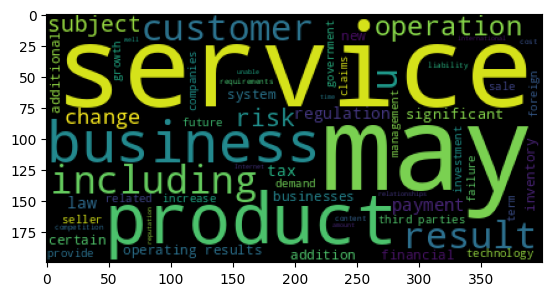

In [4]:
import pandas as pd
import numpy as np

#for plotting images & adjusting colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

wc = WordCloud().generate(section_text)
plt.imshow(wc)

In [5]:
!python -m nltk.downloader vader_lexicon

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# if you don't have vadar_lexicon data, you can run the following command in a terminal window:
#python -m nltk.downloader vader_lexicon

# download nltk corpus (first time only)
#nltk.download('all')

In [7]:
#Create a Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()
#Analyze section_text
scores = analyzer.polarity_scores(section_text)

print(scores)
#the compound key is a normalized score that ranges from -1(most negative) to 1(most positive)

{'neg': 0.086, 'neu': 0.805, 'pos': 0.109, 'compound': 0.999}


In [8]:
#We can also check which score is the highest and use that to classify the text as positive, negative, or neutral.
if scores['compound'] >= 0.5:
    print("Positive")
elif scores['compound'] >-0.5:
    print("Neutral")
else:
    print("Negative")

Positive


# FinBERT

In [9]:
import requests
from sec_api import ExtractorApi
from transformers import pipeline
import matplotlib.pyplot as plt
from collections import Counter

# Initialize sec-api with your API key
extractorApi = ExtractorApi("5f5473a28ffd33c266d5c5b7dbd3e441df3b2102cf0624b41b33c453a2193eca")  # API key

# List of Amazon's 10-K filing URLs for the past 5 years
filing_urls = [
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872425000004/amzn-20241231.htm",  # URL for 2024
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872424000008/amzn-20231231.htm",  # URL for 2023
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/amzn-20221231.htm",  # URL for 2022
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872422000005/amzn-20211231.htm",  # URL for 2021
    "https://www.sec.gov/Archives/edgar/data/1018724/000101872421000004/amzn-20201231.htm"   # URL for 2020
]

# Loop through each filing URL
for filing_url in filing_urls:
    # Extract Section 7 "Management's Discussion and Analysis of Financial Condition and Results of Operations"
    section_text = extractorApi.get_section(filing_url, "7", "text")

    # Print the extracted text
    print(f"Text from {filing_url}:\n{section_text}\n")

Text from https://www.sec.gov/Archives/edgar/data/1018724/000101872425000004/amzn-20241231.htm:
 Item 7. Management&#8217;s Discussion and Analysis of Financial Condition and Results of Operations ##TABLE_END

Forward-Looking Statements 

This Annual Report on Form 10-K includes forward-looking statements within the meaning of the Private Securities Litigation Reform Act of 1995. All statements other than statements of historical fact, including statements regarding guidance, industry prospects, or future results of operations or financial position, made in this Annual Report on Form 10-K are forward-looking. We use words such as anticipates, believes, expects, future, intends, and similar expressions to identify forward-looking statements. Forward-looking statements reflect management&#8217;s current expectations and are inherently uncertain. Actual results and outcomes could differ materially for a variety of reasons, including, among others, fluctuations in foreign exchange rates, c

Device set to use cpu


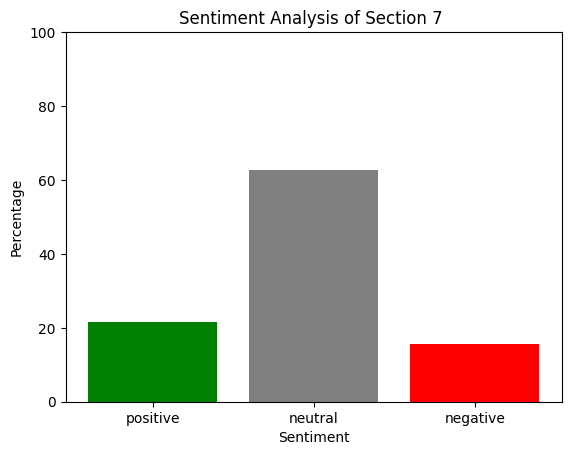

In [13]:
if section_text:
    # Load FinBERT model
    finbert = pipeline("text-classification", model="ProsusAI/finbert")

    # Split text into chunks (FinBERT has a 512-token limit)
    sentences = section_text.split(". ")
    chunk = ""
    sentiment_results = []

    for sentence in sentences:
        if len(chunk) + len(sentence) < 512:
            chunk += sentence + ". "
        else:
            sentiment_results.extend(finbert(chunk[:512]))  # Process chunk
            chunk = sentence + ". "

    # Process the last chunk if any
    if chunk:
        sentiment_results.extend(finbert(chunk[:512]))

    # Aggregate Sentiments
    labels = [res['label'].lower() for res in sentiment_results]  # ensure lowercase for consistency
    count = Counter(labels)
    total = len(sentiment_results)
    percentage = {label: round((count[label] / total) * 100, 2) for label in count}

    # Color mapping
    color_map = {
        "positive": "green",
        "neutral": "gray",
        "negative": "red"
    }

    # Sort to ensure consistent label order
    sorted_labels = ["positive", "neutral", "negative"]
    sorted_percentages = [percentage.get(label, 0) for label in sorted_labels]
    sorted_colors = [color_map[label] for label in sorted_labels]

    # Plot sentiment results
    plt.bar(sorted_labels, sorted_percentages, color=sorted_colors)
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage")
    plt.title("Sentiment Analysis of Section 7 ")
    plt.ylim(0, 100)
    plt.show()

else:
    print("Section 7 not found.")

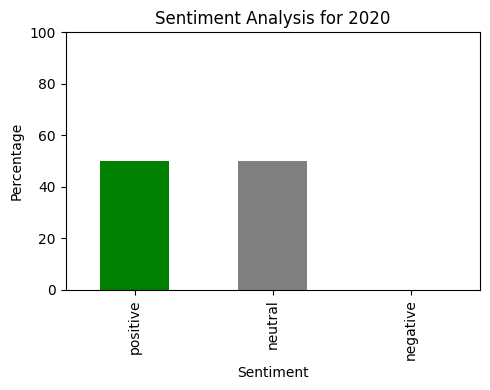

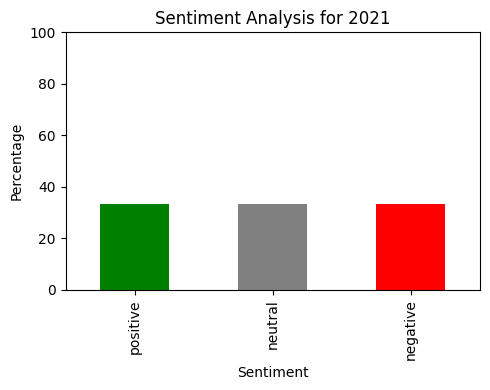

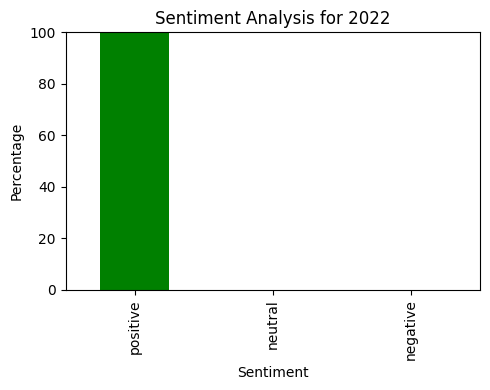

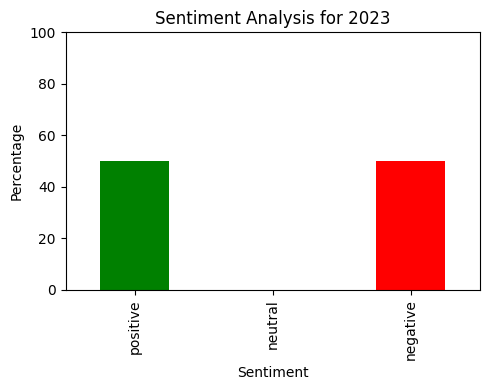

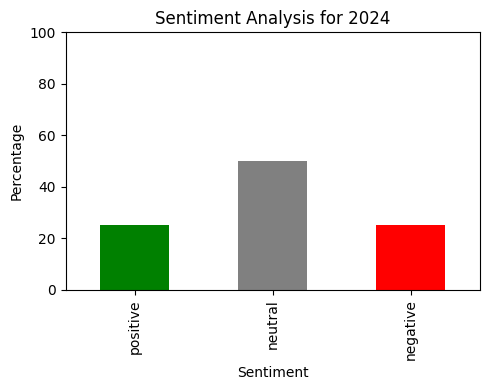

In [11]:
years = [2020, 2020, 2021, 2021, 2021, 2022, 2023, 2023, 2024, 2024, 2024, 2024]
sentiments = ["positive", "neutral", "negative", "positive", "neutral",
              "positive", "negative", "positive", "neutral", "positive", "negative", "neutral"]

df = pd.DataFrame({
    'year': years,
    'sentiment': sentiments
})

# Fixed sentiment order and colors
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_colors = ['green', 'gray', 'red']

# Plot each year separately
for year in range(2020, 2025):
    yearly_data = df[df['year'] == year]
    sentiment_counts = yearly_data['sentiment'].value_counts(normalize=True) * 100  # percentage

    # Ensure consistent order and fill missing sentiments with 0
    sentiment_counts = sentiment_counts.reindex(sentiment_order, fill_value=0)

    plt.figure(figsize=(5, 4))
    sentiment_counts.plot(kind='bar', color=sentiment_colors)

    plt.title(f'Sentiment Analysis for {year}')
    plt.ylabel('Percentage')
    plt.xlabel('Sentiment')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

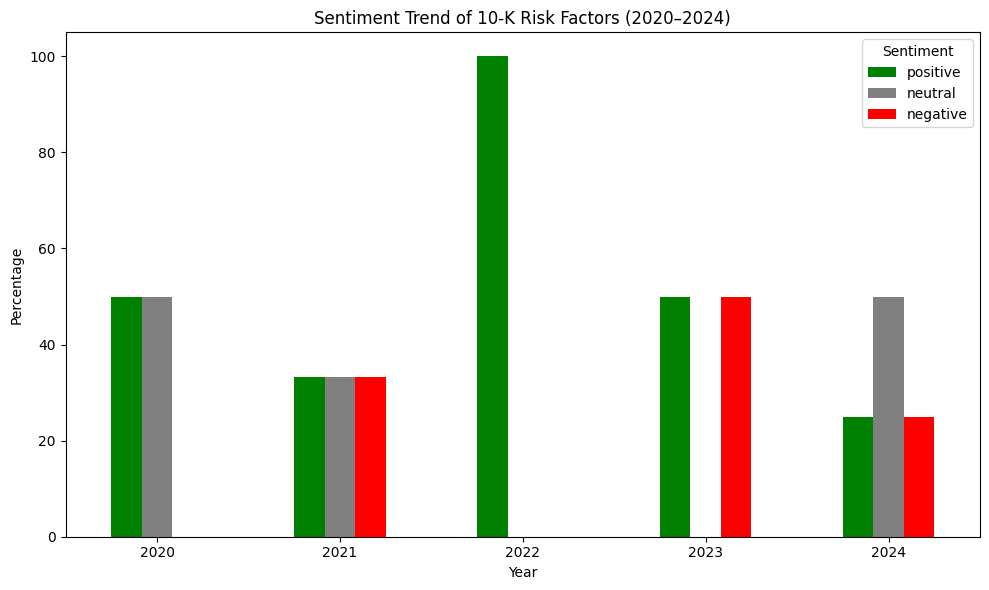

In [12]:
years = [2020, 2020, 2021, 2021, 2021, 2022, 2023, 2023, 2024, 2024, 2024, 2024]
sentiments = ["positive", "neutral", "negative", "positive", "neutral",
              "positive", "negative", "positive", "neutral", "positive", "negative", "neutral"]

df = pd.DataFrame({
    'year': years,
    'sentiment': sentiments
})

# Filter to include only years 2020–2024
df = df[df['year'].isin([2020, 2021, 2022, 2023, 2024])]

# Count each sentiment per year
sentiment_counts = df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# Reorder columns to match sentiment-color mapping
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_counts = sentiment_counts.reindex(columns=sentiment_order, fill_value=0)

# Convert to percentage
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Plot
sentiment_percentages.plot(kind='bar', figsize=(10, 6), color=['green', 'gray', 'red'])

plt.title('Sentiment Trend of 10-K Risk Factors (2020–2024)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()